In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.metrics import classification_report, precision_score, accuracy_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn import neighbors

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [35]:
df = pd.read_csv("Bike Sharing Dataset.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  object 
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  object 
 7   weekday     17379 non-null  object 
 8   workingday  17379 non-null  object 
 9   weathersit  17379 non-null  object 
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(6), object(7)
memory usage: 2.3+ MB


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/01/2011,spring,0,january,0,no,saturday,no,clear,0.24,0.2879,0.81,0.0,3,13,16
1,2,1/01/2011,spring,0,january,1,no,saturday,no,clear,0.22,0.2727,0.80,0.0,8,32,40
2,3,1/01/2011,spring,0,january,2,no,saturday,no,clear,0.22,0.2727,0.80,0.0,5,27,32
3,4,1/01/2011,spring,0,january,3,no,saturday,no,clear,0.24,0.2879,0.75,0.0,3,10,13
4,5,1/01/2011,spring,0,january,4,no,saturday,no,clear,0.24,0.2879,0.75,0.0,0,1,1


In [36]:
df['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

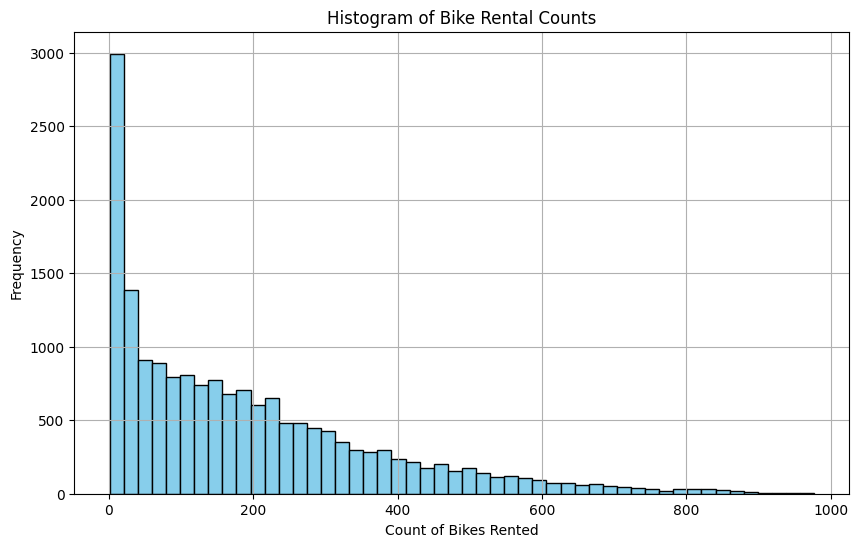

In [37]:
plt.figure(figsize=(10,6))
plt.hist(df['cnt'], bins=50, color='skyblue', edgecolor='black')

plt.title('Histogram of Bike Rental Counts')
plt.xlabel('Count of Bikes Rented')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

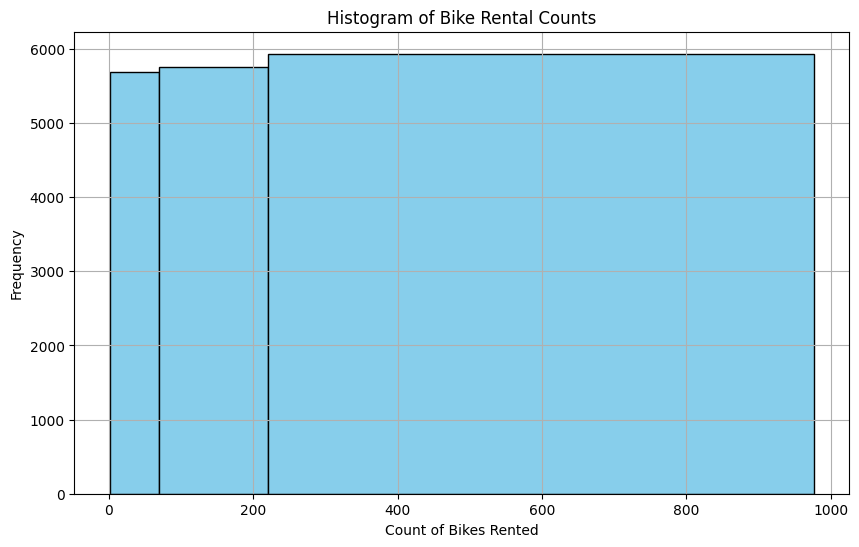

In [38]:
percentiles = [0,33,66,100]
custom_bins = [df['cnt'].quantile(p/100) for p in percentiles]

plt.figure(figsize=(10,6))
plt.hist(df['cnt'], bins=custom_bins, color='skyblue', edgecolor='black')

plt.title('Histogram of Bike Rental Counts')
plt.xlabel('Count of Bikes Rented')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Split data into quantiles (in this case, thirds)

In [39]:
quartiles = [0, 0.33, 0.66, 1]
df['quartile'] = pd.qcut(df['cnt'], quartiles, labels=['T1', 'T2', 'T3'])
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,quartile
0,1,1/01/2011,spring,0,january,0,no,saturday,no,clear,0.24,0.2879,0.81,0.0,3,13,16,T1
1,2,1/01/2011,spring,0,january,1,no,saturday,no,clear,0.22,0.2727,0.80,0.0,8,32,40,T1
2,3,1/01/2011,spring,0,january,2,no,saturday,no,clear,0.22,0.2727,0.80,0.0,5,27,32,T1
3,4,1/01/2011,spring,0,january,3,no,saturday,no,clear,0.24,0.2879,0.75,0.0,3,10,13,T1
4,5,1/01/2011,spring,0,january,4,no,saturday,no,clear,0.24,0.2879,0.75,0.0,0,1,1,T1


#### Set X, y feature sets and encode X categorical values

In [40]:
y = df['quartile']
X = df.drop(['quartile', 'dteday', 'instant', 'cnt', 'registered', 'casual'], axis=1)

scaler = StandardScaler()
X_encoded = pd.get_dummies(X)
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     17379 non-null  int64  
 1   hr                     17379 non-null  int64  
 2   temp                   17379 non-null  float64
 3   atemp                  17379 non-null  float64
 4   hum                    17379 non-null  float64
 5   windspeed              17379 non-null  float64
 6   season_autumn          17379 non-null  uint8  
 7   season_spring          17379 non-null  uint8  
 8   season_summer          17379 non-null  uint8  
 9   season_winter          17379 non-null  uint8  
 10  mnth_april             17379 non-null  uint8  
 11  mnth_august            17379 non-null  uint8  
 12  mnth_december          17379 non-null  uint8  
 13  mnth_february          17379 non-null  uint8  
 14  mnth_january           17379 non-null  uint8  
 15  mn

#### Multiple Logistic Regression Model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = skl_lm.LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6594
Precision: 0.6518
Recall: 0.6594
F1 Score: 0.6503

Classification Report:
              precision    recall  f1-score   support

          T1       0.69      0.82      0.75      1139
          T2       0.59      0.45      0.51      1190
          T3       0.68      0.71      0.69      1147

    accuracy                           0.66      3476
   macro avg       0.65      0.66      0.65      3476
weighted avg       0.65      0.66      0.65      3476



### PCA

In [42]:
#X_scaled = scaler.fit_transform(X_encoded)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_encoded)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = skl_lm.LogisticRegression(random_state=42, max_iter=1000, solver='sag')

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6243
Precision: 0.6164
Recall: 0.6243
F1 Score: 0.6169

Classification Report:
              precision    recall  f1-score   support

          T1       0.67      0.79      0.73      1139
          T2       0.54      0.44      0.49      1190
          T3       0.64      0.65      0.64      1147

    accuracy                           0.62      3476
   macro avg       0.62      0.63      0.62      3476
weighted avg       0.62      0.62      0.62      3476



#### TSNE

In [44]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = skl_lm.LogisticRegression(random_state=42, max_iter=1000, solver='sag')

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5020
Precision: 0.4304
Recall: 0.5020
F1 Score: 0.4290

Classification Report:
              precision    recall  f1-score   support

          T1       0.62      0.81      0.70      1139
          T2       0.25      0.04      0.07      1190
          T3       0.43      0.67      0.53      1147

    accuracy                           0.50      3476
   macro avg       0.43      0.51      0.43      3476
weighted avg       0.43      0.50      0.43      3476



#### Decision Tree

In [45]:
"""
tree_parameters = {
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'criterion': 'gini',
    'random_state': 42
}
"""

tree_model = DecisionTreeClassifier(random_state=42) #**tree_parameters

tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

In [46]:
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print("\nTree-based Model (Decision Tree) Performance:")
print(f"Accuracy: {accuracy_tree:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))


Tree-based Model (Decision Tree) Performance:
Accuracy: 0.7957
Classification Report:
              precision    recall  f1-score   support

          T1       0.87      0.87      0.87      1139
          T2       0.72      0.70      0.71      1190
          T3       0.80      0.82      0.81      1147

    accuracy                           0.80      3476
   macro avg       0.80      0.80      0.80      3476
weighted avg       0.80      0.80      0.80      3476



#### Decision Tree with test for hyperparameters

In [47]:
param_ = {
    'max_depth': [21,22],
    'min_samples_split': [19,20],
    'min_samples_leaf': [1,3,5,7],
    'max_features': [None],
    'criterion': ['gini']
}

tree_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:")
print(grid_search.best_params_)
best_tree_model = grid_search.best_estimator_
y_pred_tree = best_tree_model.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Accuracy: {accuracy_tree:.4f}")

Best Hyperparameters:
{'criterion': 'gini', 'max_depth': 21, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 19}
Accuracy: 0.7739


#### Visualization of Dataframe

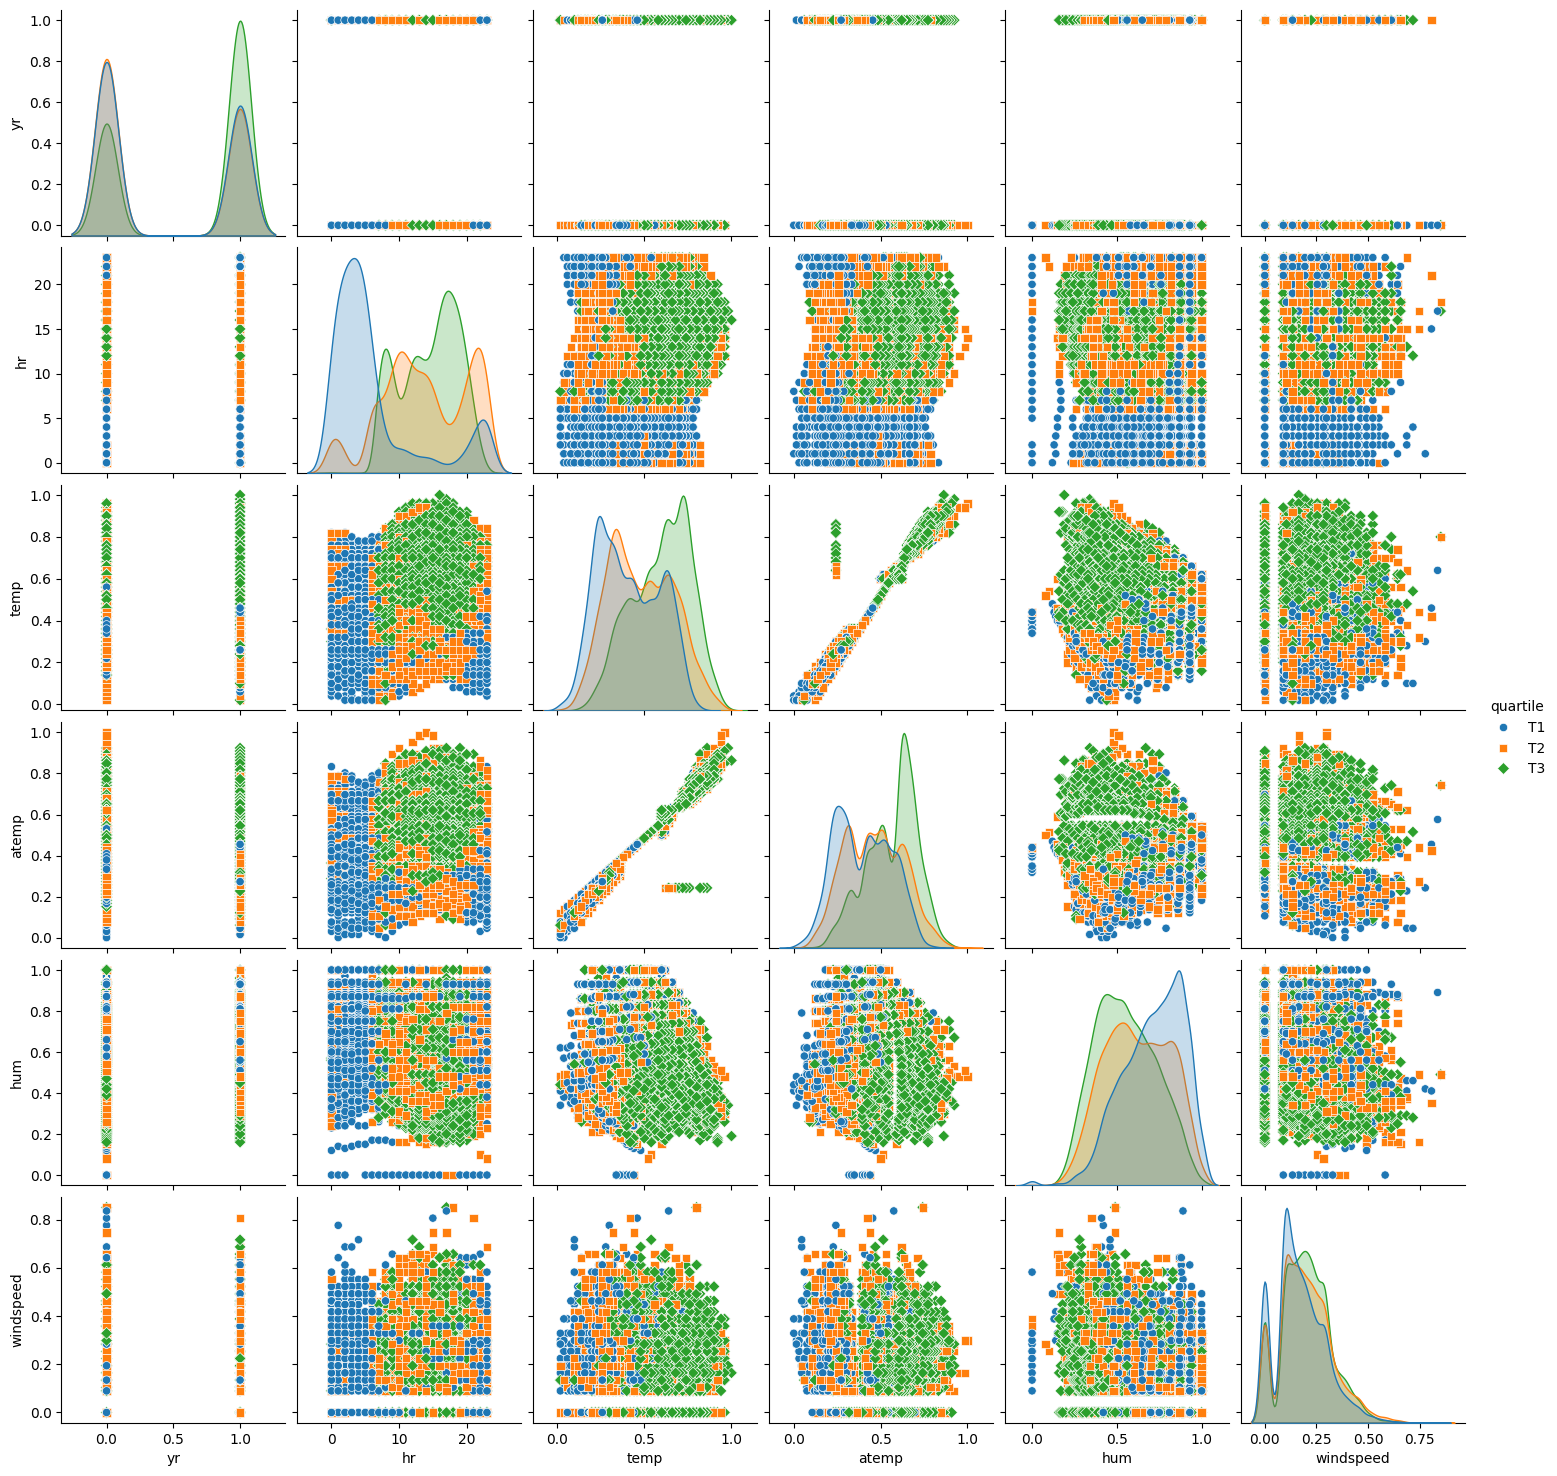

In [48]:
df_visualization = pd.concat([X, y], axis=1)

sns.pairplot(df_visualization, hue='quartile', markers=['o', 's', 'D'])
plt.show()

#### KNN

In [49]:
k = 10
knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

In [50]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.7675

Classification Report:
              precision    recall  f1-score   support

          T1       0.84      0.88      0.86      1139
          T2       0.67      0.67      0.67      1190
          T3       0.80      0.76      0.78      1147

    accuracy                           0.77      3476
   macro avg       0.77      0.77      0.77      3476
weighted avg       0.77      0.77      0.77      3476



#### Random Forest with hyperparameters test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=42)

rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [125],
    'max_depth': [None],
    'min_samples_split': [5,7],
    'min_samples_leaf': [1]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 125}
Accuracy: 0.8677

Classification Report:
              precision    recall  f1-score   support

          T1       0.93      0.90      0.91       593
          T2       0.78      0.83      0.80       558
          T3       0.90      0.88      0.89       587

    accuracy                           0.87      1738
   macro avg       0.87      0.87      0.87      1738
weighted avg       0.87      0.87      0.87      1738



In [52]:
y_pred = best_model.predict(X_encoded)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y, y_pred))
print(y.head())

Accuracy: 0.9564

Classification Report:
              precision    recall  f1-score   support

          T1       0.98      0.96      0.97      5748
          T2       0.93      0.94      0.94      5727
          T3       0.96      0.96      0.96      5904

    accuracy                           0.96     17379
   macro avg       0.96      0.96      0.96     17379
weighted avg       0.96      0.96      0.96     17379

0    T1
1    T1
2    T1
3    T1
4    T1
Name: quartile, dtype: category
Categories (3, object): ['T1' < 'T2' < 'T3']


#### Feature importance

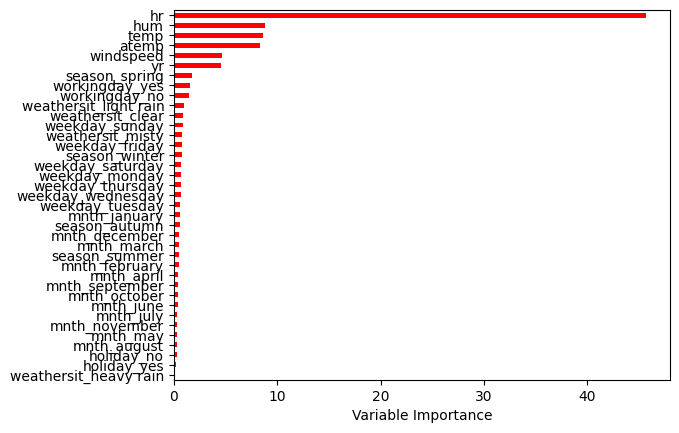

In [53]:


Importance = pd.DataFrame({'Importance':best_model.feature_importances_*100}, index=X_test.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

#### Split Dataframe into three quantiles

In [54]:
df_ = df.drop(['dteday', 'instant', 'registered', 'casual'], axis=1)

categorical_columns = df_.select_dtypes(include='object').columns
numerical_integer_columns = df_.select_dtypes(include='int64').columns
numerical_float_columns = df_.select_dtypes(include='float64').columns

df_dummy = pd.get_dummies(df_, columns=categorical_columns)

df_dict = dict(tuple(df_dummy.groupby('quartile')))

df_T1 = df_dict['T1']
df_T2 = df_dict['T2']
df_T3 = df_dict['T3']

print(df_T3.head())

     yr  hr  temp   atemp   hum  windspeed  cnt quartile  season_autumn  \
439   0   8  0.22  0.2121  0.55     0.2836  249       T3              0   
555   0   8  0.16  0.1818  0.74     0.1343  238       T3              0   
564   0  17  0.30  0.3333  0.45     0.0000  222       T3              0   
565   0  18  0.30  0.3182  0.49     0.0896  225       T3              0   
837   0   8  0.16  0.2273  1.00     0.0000  230       T3              0   

     season_spring  ...  weekday_sunday  weekday_thursday  weekday_tuesday  \
439              1  ...               0                 1                0   
555              1  ...               0                 0                1   
564              1  ...               0                 0                1   
565              1  ...               0                 0                1   
837              1  ...               0                 0                0   

     weekday_wednesday  workingday_no  workingday_yes  weathersit_clear  \
439  

In [55]:
def train_lasso_ridge_model(df, alpha, model_type='lasso'):

    y = df['cnt']
    X = df.drop(['quartile','cnt'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_type == 'lasso':
        model = Lasso(alpha=alpha, max_iter=10000)
    elif model_type == 'ridge':
        model = Ridge(alpha=alpha, max_iter=10000)
    else:
        raise ValueError("Invalid model type.")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_type.capitalize()} Regression - Mean Squared Error: {mse}")

    return model

#### Training Three different models on the quantiles

In [56]:
alpha = .1

lasso_model_T1 = train_lasso_ridge_model(df_T1, alpha, model_type='lasso')
ridge_model_T1 = train_lasso_ridge_model(df_T1, alpha, model_type='ridge')

lasso_model_T2 = train_lasso_ridge_model(df_T2, alpha, model_type='lasso')
ridge_model_T2 = train_lasso_ridge_model(df_T2, alpha, model_type='ridge')

lasso_model_T3 = train_lasso_ridge_model(df_T3, alpha, model_type='lasso')
ridge_model_T3 = train_lasso_ridge_model(df_T3, alpha, model_type='ridge')

#lasso_model_ = train_lasso_ridge_model(df, alpha, model_type='lasso')
#ridge_model_ = train_lasso_ridge_model(df, alpha, model_type='ridge')

Lasso Regression - Mean Squared Error: 306.61664146351285
Ridge Regression - Mean Squared Error: 304.9895250194102
Lasso Regression - Mean Squared Error: 1585.7895394563727
Ridge Regression - Mean Squared Error: 1579.5510456665866
Lasso Regression - Mean Squared Error: 19768.80927434785
Ridge Regression - Mean Squared Error: 19805.49777591074


In [57]:
df2 = pd.read_csv("Bike Sharing Dataset.csv")
df2.head()
X2 = df2.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
X2.info()

X_dummy = pd.get_dummies(X2, columns=categorical_columns)

y_pred2 = best_model.predict(X_dummy.drop('cnt', axis=1))

y_pred2 = np.atleast_2d(y_pred2).T

df_concat = np.concatenate([X_dummy, y_pred2], axis=1)

column_titles = X_dummy.columns.tolist()
column_titles.append('quartile')

df3 = pd.DataFrame(df_concat, columns=column_titles)

df3_dict = dict(tuple(df3.groupby('quartile')))

df3_T1 = df3_dict['T1']
df3_T2 = df3_dict['T2']
df3_T3 = df3_dict['T3']

y1_pred = np.round(lasso_model_T1.predict(df3_T1.drop(['quartile', 'cnt'], axis=1))).astype(int)
y2_pred = np.round(lasso_model_T2.predict(df3_T2.drop(['quartile', 'cnt'], axis=1))).astype(int)
y3_pred = np.round(lasso_model_T3.predict(df3_T3.drop(['quartile', 'cnt'], axis=1))).astype(int)

y1_pred = np.atleast_2d(y1_pred).T
y2_pred = np.atleast_2d(y2_pred).T
y3_pred = np.atleast_2d(y3_pred).T

T1_concat = np.concatenate([df3_T1,y1_pred], axis=1)
column_titles = df3_T1.columns.tolist()
column_titles.append('cnt_pred')
T1 = pd.DataFrame(T1_concat, columns=column_titles)
print(f"T1 Lasso MSE: {mean_squared_error(T1['cnt'], T1['cnt_pred'])}")
print(f"T1 Lasso R2: {r2_score(T1['cnt'], T1['cnt_pred'])}")

T2_concat = np.concatenate([df3_T2,y2_pred], axis=1)
column_titles = df3_T2.columns.tolist()
column_titles.append('cnt_pred')
T2 = pd.DataFrame(T2_concat, columns=column_titles)
print(f"T2 Lasso MSE: {mean_squared_error(T2['cnt'], T2['cnt_pred'])}")
print(f"T2 Lasso R2: {r2_score(T2['cnt'], T2['cnt_pred'])}")

T3_concat = np.concatenate([df3_T3,y3_pred], axis=1)
column_titles = df3_T3.columns.tolist()
column_titles.append('cnt_pred')
T3 = pd.DataFrame(T3_concat, columns=column_titles)

print(T3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  object 
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  object 
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  object 
 5   weekday     17379 non-null  object 
 6   workingday  17379 non-null  object 
 7   weathersit  17379 non-null  object 
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 1.7+ MB
T1 Lasso MSE: 462.7492927864215
T1 Lasso R2: 0.14649598317256896
T2 Lasso MSE: 2476.3453953009775
T2 Lasso R2: 0.07868412602400665
    yr    hr  temp   atemp   hum windspeed    cnt season_autumn season_spring  \
0 

In [58]:
y1_pred = np.round(ridge_model_T1.predict(df3_T1.drop(['quartile', 'cnt'], axis=1))).astype(int)
y2_pred = np.round(ridge_model_T2.predict(df3_T2.drop(['quartile', 'cnt'], axis=1))).astype(int)
y3_pred = np.round(ridge_model_T3.predict(df3_T3.drop(['quartile', 'cnt'], axis=1))).astype(int)

y1_pred = np.atleast_2d(y1_pred).T
y2_pred = np.atleast_2d(y2_pred).T
y3_pred = np.atleast_2d(y3_pred).T

T1_concat = np.concatenate([df3_T1,y1_pred], axis=1)
column_titles = df3_T1.columns.tolist()
column_titles.append('cnt_pred')
T1 = pd.DataFrame(T1_concat, columns=column_titles)

T2_concat = np.concatenate([df3_T2,y2_pred], axis=1)
column_titles = df3_T2.columns.tolist()
column_titles.append('cnt_pred')
T2 = pd.DataFrame(T2_concat, columns=column_titles)

T3_concat = np.concatenate([df3_T3,y3_pred], axis=1)
column_titles = df3_T3.columns.tolist()
column_titles.append('cnt_pred')
T3 = pd.DataFrame(T3_concat, columns=column_titles)